In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from statannotations.Annotator import Annotator

In [2]:
plt.rcParams["font.family"] = "Times New Roman"
sns.set(rc={'text.usetex' : True})
sns.set_style("whitegrid")
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

In [3]:
train_values_df = pd.read_csv('./results/agreeing-to-disagree-data-train_values_5_epochs.csv', index_col=0)
train_values_df.head()

,text_id,label_0,label_1,epoch_no,id,text,label,agreement_level,agreement_factor,pred
0,3863,0.554797,0.445203,1,3158_train,"No joe, you’re confused again. That would be ...",0,A+,0.8,0
1,1412,0.555315,0.444685,1,1758_test,China is mocking trump supporters. <url>,0,A0,0.6,0
2,2195,0.508891,0.491109,1,2176_test,Headlines like this piss me the fuck off. This...,0,A0,0.6,0
3,6334,0.483924,0.516076,1,5513_train,While No man should die the way George Floyd d...,0,A+,0.8,1
4,7475,0.551025,0.448975,1,6571_train,We have a stupid pandemic to go along with a C...,0,A+,0.8,0


In [4]:
len(train_values_df['text_id'].unique())

8357

Retaining only 5 epochs

In [6]:
train_values_df = train_values_df[train_values_df['epoch_no'] < 6]
train_values_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41785 entries, 0 to 41784
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   text_id           41785 non-null  int64  
 1   label_0           41785 non-null  float64
 2   label_1           41785 non-null  float64
 3   epoch_no          41785 non-null  int64  
 4   id                41785 non-null  object 
 5   text              41785 non-null  object 
 6   label             41785 non-null  int64  
 7   agreement_level   41785 non-null  object 
 8   agreement_factor  41785 non-null  float64
 9   pred              41785 non-null  int64  
dtypes: float64(3), int64(4), object(3)
memory usage: 3.5+ MB


In [7]:
def get_confidence(label, label_0_mean, label_1_mean):
    if label == 0:
        return label_0_mean
    else:
        return label_1_mean

def get_variability(label, label_0_std, label_1_std):
    if label == 0:
        return label_0_std
    else: return label_1_std

def get_correctness(label, label_0_last, label_1_last):
    if label == 0:
        return label_0_last
    else:
        return label_1_last

In [8]:
metrics = ['mean', 'std', 'last']
def build_cartography_df(train_values_df):
    agg_df = train_values_df.sort_values(['epoch_no']).groupby('text_id', as_index=False).agg({'text': 'first', 'label_0': metrics, 'label_1': metrics, 'label': 'first', 'pred': 'last', 'agreement_level': 'first', 'agreement_factor': 'first', 'id':'first'})
    agg_df.columns = ['text_id', 'text', 'label_0_mean', 'label_0_std', 'label_0_last', 'label_1_mean', 'label_1_std', 'label_1_last', 'label', 'pred', 'agreement_level', 'agreement_factor', 'comment_id']

    agg_df['confidence'] = agg_df.apply(lambda row: get_confidence(row.label, row.label_0_mean, row.label_1_mean), axis=1)
    agg_df['variability'] = agg_df.apply(lambda row: get_variability(row.label, row.label_0_std, row.label_1_std), axis=1)
    agg_df['correctness'] = agg_df.apply(lambda row: get_correctness(row.label, row.label_0_last, row.label_1_last), axis=1)
    agg_df['is_correct'] = np.where((agg_df['label'] == agg_df['pred']), True, False)

    return agg_df

In [9]:
cartography_df = build_cartography_df(train_values_df)
cartography_df.head()

,text_id,text,label_0_mean,label_0_std,label_0_last,label_1_mean,label_1_std,label_1_last,label,pred,agreement_level,agreement_factor,comment_id,confidence,variability,correctness,is_correct
0,0,MR OBAMA IF YOUR COMPLAINING ABOUT THE WAY TH...,0.776900,0.195709,0.997088,0.223100,0.195709,0.002912,0,0,A+,0.8,1000_test,0.776900,0.195709,0.997088,True
1,1,The High Priest of COVID-19 Speaks.... Bill G...,0.396611,0.357260,0.045499,0.603389,0.357260,0.954501,1,1,A+0,0.6,1000_train,0.603389,0.357260,0.954501,True
2,2,Do you know what sarcasm means?,0.935119,0.067998,0.998300,0.064881,0.067998,0.001700,0,0,A++,1.0,1001_test,0.935119,0.067998,0.998300,True
3,3,"Politicians, not scientists. Like we are goin...",0.764697,0.204913,0.991857,0.235303,0.204913,0.008143,0,0,A++,1.0,1001_train,0.764697,0.204913,0.991857,True
4,4,Four more years of tRump &amp; our country ...,0.863673,0.200856,0.997282,0.136327,0.200856,0.002718,0,0,A0,0.6,1002_dev,0.863673,0.200856,0.997282,True


In [10]:
cartography_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8357 entries, 0 to 8356
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   text_id           8357 non-null   int64  
 1   text              8357 non-null   object 
 2   label_0_mean      8357 non-null   float64
 3   label_0_std       8357 non-null   float64
 4   label_0_last      8357 non-null   float64
 5   label_1_mean      8357 non-null   float64
 6   label_1_std       8357 non-null   float64
 7   label_1_last      8357 non-null   float64
 8   label             8357 non-null   int64  
 9   pred              8357 non-null   int64  
 10  agreement_level   8357 non-null   object 
 11  agreement_factor  8357 non-null   float64
 12  comment_id        8357 non-null   object 
 13  confidence        8357 non-null   float64
 14  variability       8357 non-null   float64
 15  correctness       8357 non-null   float64
 16  is_correct        8357 non-null   bool   


In [11]:
# cartography_df = pd.read_csv('./results/agreeing-to-disagree-data-cartography.csv', index_col=0)
# cartography_df.head()

In [12]:
len(cartography_df['text_id'].unique())

8357

In [13]:
len(cartography_df)

8357

In [14]:
def round_agree_factor(agr_factor):
    if agr_factor <= 0.6:
        return 0.6
    elif agr_factor <= 0.8:
        return 0.8
    return 1.0

cartography_df['agreement_factor_rd'] = cartography_df['agreement_factor'].apply(lambda x: round_agree_factor(x))
cartography_df.head()

,text_id,text,label_0_mean,label_0_std,label_0_last,label_1_mean,label_1_std,label_1_last,label,pred,agreement_level,agreement_factor,comment_id,confidence,variability,correctness,is_correct,agreement_factor_rd
0,0,MR OBAMA IF YOUR COMPLAINING ABOUT THE WAY TH...,0.776900,0.195709,0.997088,0.223100,0.195709,0.002912,0,0,A+,0.8,1000_test,0.776900,0.195709,0.997088,True,0.8
1,1,The High Priest of COVID-19 Speaks.... Bill G...,0.396611,0.357260,0.045499,0.603389,0.357260,0.954501,1,1,A+0,0.6,1000_train,0.603389,0.357260,0.954501,True,0.6
2,2,Do you know what sarcasm means?,0.935119,0.067998,0.998300,0.064881,0.067998,0.001700,0,0,A++,1.0,1001_test,0.935119,0.067998,0.998300,True,1.0
3,3,"Politicians, not scientists. Like we are goin...",0.764697,0.204913,0.991857,0.235303,0.204913,0.008143,0,0,A++,1.0,1001_train,0.764697,0.204913,0.991857,True,1.0
4,4,Four more years of tRump &amp; our country ...,0.863673,0.200856,0.997282,0.136327,0.200856,0.002718,0,0,A0,0.6,1002_dev,0.863673,0.200856,0.997282,True,0.6


In [15]:
len(cartography_df)

8357

In [14]:
cartography_df.to_csv('./results/cartography_majority.csv', index=False)

In [5]:
cartography_df = pd.read_csv('./results/cartography_majority.csv')
cartography_df.head()

,text_id,text,label_0_mean,label_0_std,label_0_last,label_1_mean,label_1_std,label_1_last,label,pred,agreement_level,agreement_factor,comment_id,confidence,variability,correctness,is_correct,agreement_factor_rd
0,0,MR OBAMA IF YOUR COMPLAINING ABOUT THE WAY TH...,0.776900,0.195709,0.997088,0.223100,0.195709,0.002912,0,0,A+,0.8,1000_test,0.776900,0.195709,0.997088,True,0.8
1,1,The High Priest of COVID-19 Speaks.... Bill G...,0.396611,0.357260,0.045499,0.603389,0.357260,0.954501,1,1,A+0,0.6,1000_train,0.603389,0.357260,0.954501,True,0.6
2,2,Do you know what sarcasm means?,0.935119,0.067998,0.998300,0.064881,0.067998,0.001700,0,0,A++,1.0,1001_test,0.935119,0.067998,0.998300,True,1.0
3,3,"Politicians, not scientists. Like we are goin...",0.764697,0.204913,0.991857,0.235303,0.204913,0.008143,0,0,A++,1.0,1001_train,0.764697,0.204913,0.991857,True,1.0
4,4,Four more years of tRump &amp; our country ...,0.863673,0.200856,0.997282,0.136327,0.200856,0.002718,0,0,A0,0.6,1002_dev,0.863673,0.200856,0.997282,True,0.6


### Useless after this

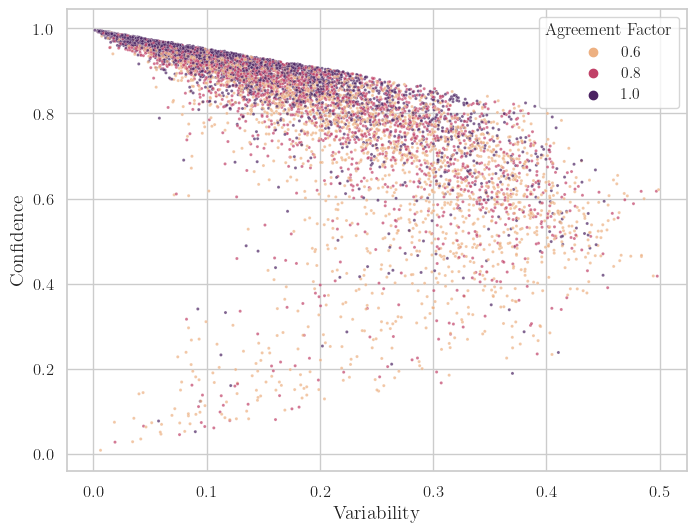

In [6]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=cartography_df, x="variability", y="confidence", hue='agreement_factor_rd', palette='flare', alpha=0.7, s=5)

plt.gca().legend().set_title(str(plt.gca().legend().get_title()).capitalize())
plt.gca().set_xlabel(str(plt.gca().get_xlabel()).capitalize(), fontsize=14)
plt.gca().set_ylabel(str(plt.gca().get_ylabel()).capitalize(), fontsize=14)
plt.legend(title='Agreement Factor')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("./plots/majority/conf_vs_var_color_agreement_factor.png", dpi=600, bbox_inches='tight')

In [7]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.6 vs. 0.8: Mann-Whitney-Wilcoxon test two-sided, P_val:1.660e-91 U_stat=1.957e+06
0.8 vs. 1.0: Mann-Whitney-Wilcoxon test two-sided, P_val:5.624e-152 U_stat=2.579e+06
0.6 vs. 1.0: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=1.459e+06


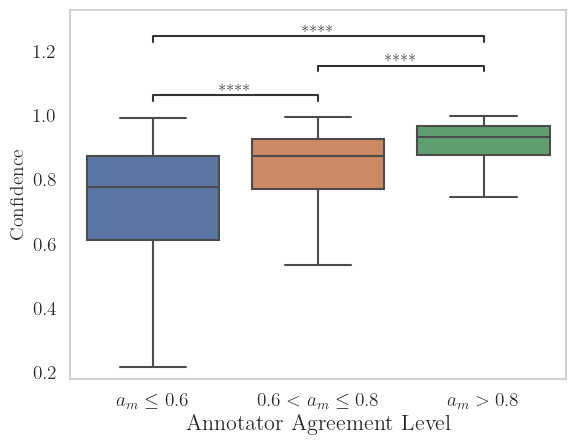

In [8]:
ax = sns.boxplot(data=cartography_df, x="agreement_factor", y="confidence", showfliers=False)

pairs=[(0.6, 0.8), (0.8, 1.0), (0.6, 1.0)]

annotator = Annotator(ax, pairs, data=cartography_df, x="agreement_factor", y="confidence")
annotator.configure(test='Mann-Whitney', text_format='star')
annotator.apply_and_annotate()

csfont = {'fontname':'Times New Roman'}
ax.grid(False)
plt.gca().set_ylabel('Confidence', fontsize=14, **csfont)
plt.gca().set_xlabel('Annotator Agreement Level', fontsize=16, **csfont)
# plt.xticks(fontsize=14)
plt.xticks([0, 1, 2], [r'$a_m \leq 0.6$', r'$0.6 < a_m \leq 0.8$', r'$a_m > 0.8$',], fontsize=14)
plt.yticks(fontsize=14)
# plt.savefig("./plots/majority/agr_factor_vs_conf.png", dpi=600, bbox_inches='tight')
plt.savefig("./plots/majority/ag2disagree_agr_factor_vs_conf.png", dpi=600, bbox_inches='tight')



In [9]:
cartography_df['label_text'] = cartography_df['label'].map({0: 'not offensive', 1: 'offensive'})

In [10]:
len(cartography_df)

8357

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.6_0 vs. 1.0_0: Mann-Whitney-Wilcoxon test two-sided, P_val:3.794e-233 U_stat=6.935e+05
0.6_1 vs. 1.0_1: Mann-Whitney-Wilcoxon test two-sided, P_val:2.649e-75 U_stat=1.728e+05


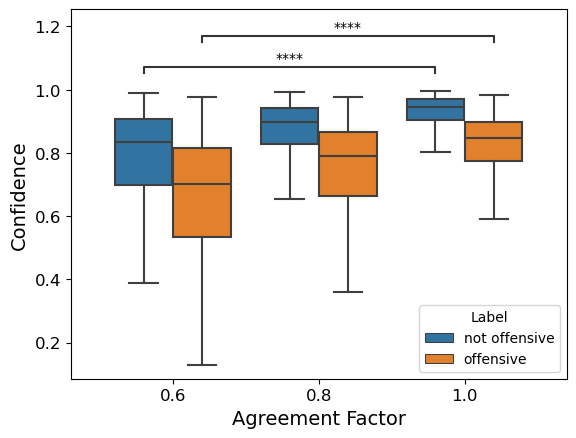

In [35]:
ax = sns.boxplot(data=cartography_df, x="agreement_factor", y="confidence", showfliers=False, hue='label_text')


pairs=[ ((0.6, 0), (1.0, 0)), ((0.6, 1), (1.0, 1))]


annotator = Annotator(ax, pairs, data=cartography_df, x="agreement_factor", y="confidence", hue='label')
annotator.configure(test='Mann-Whitney', text_format='star')
annotator.apply_and_annotate()
plt.gca().set_ylabel(str(plt.gca().get_ylabel()).capitalize(), fontsize=14)
plt.gca().set_xlabel('Agreement Factor', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title = 'Label')
plt.savefig("./plots/majority/agr_factor_vs_conf_hue.png", dpi=600, bbox_inches='tight')

In [47]:
cartography_df['label'].value_counts()

0    4630
1    1962
Name: label, dtype: int64

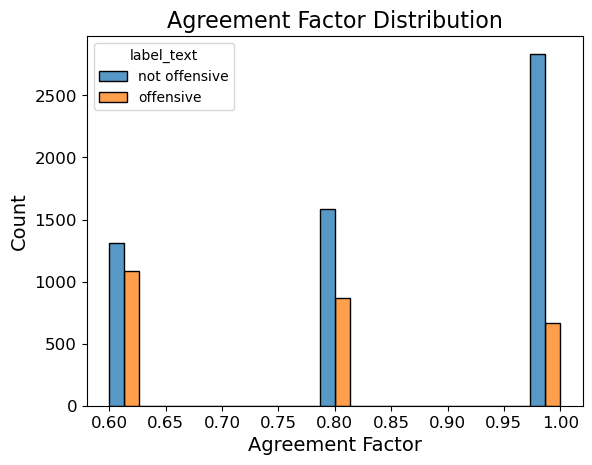

In [34]:
# sns.histplot(data=cartography_df, x="agreement_factor",hue='label')
sns.histplot(data=cartography_df, x="agreement_factor", hue='label_text', multiple='dodge')

plt.title("Agreement Factor Distribution", fontsize=16)
plt.gca().set_xlabel(str(plt.gca().get_xlabel()).capitalize(), fontsize=14)
plt.gca().set_ylabel(str(plt.gca().get_ylabel()).capitalize(), fontsize=14)
plt.gca().set_xlabel('Agreement Factor', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("./plots/majority/agr_factor_hist.png", dpi=600, bbox_inches='tight')

In [12]:
def round_correctness(value):
    return round(value*5)/5

In [13]:
cartography_df['correctness_rd'] = cartography_df['correctness'].apply(lambda x: round_correctness(x))

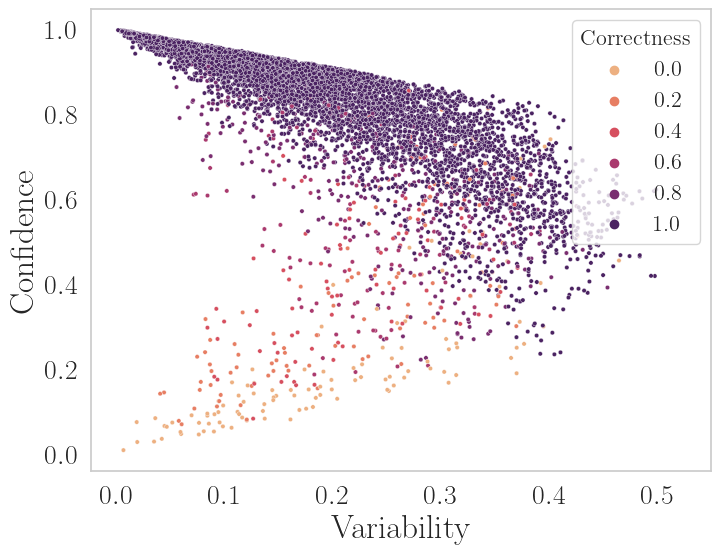

In [14]:
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(data=cartography_df, x="variability", y="confidence", hue='correctness_rd', palette='flare',  s=10, edgecolors=None)

plt.gca().legend().set_title(str(plt.gca().legend().get_title()).capitalize())
plt.gca().set_xlabel(str(plt.gca().get_xlabel()).capitalize(), fontsize=24)
plt.gca().set_ylabel(str(plt.gca().get_ylabel()).capitalize(), fontsize=24)
plt.gca().set_xlim(right=0.55)
ax.grid(False)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
legend = plt.legend(title='Correctness', loc='upper right', fontsize=16)
plt.setp(legend.get_title(), fontsize=16)
plt.savefig("./plots/majority/ag2disagree_conf_vs_var_color_correctness.png", dpi=600, bbox_inches='tight')

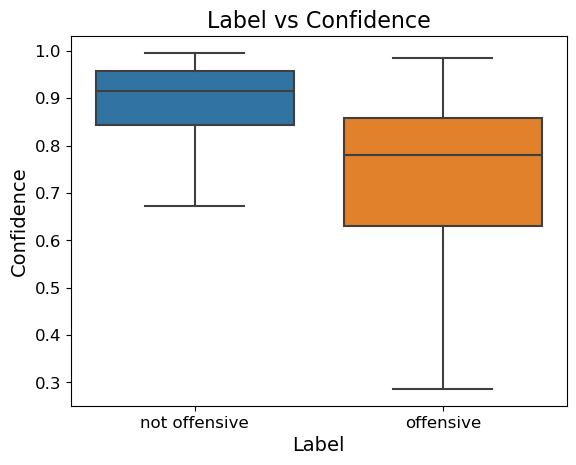

In [33]:
sns.boxplot(data=cartography_df, x="label_text", y="confidence", showfliers=False)
plt.title("Label vs Confidence", fontsize=16)
plt.gca().set_ylabel(str(plt.gca().get_ylabel()).capitalize(), fontsize=14)
plt.gca().set_xlabel('Label', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("./plots/majority/label_vs_conf.png", dpi=600, bbox_inches='tight')

In [40]:
from scipy.stats import pearsonr

pearsonr(cartography_df['confidence'], cartography_df['agreement_factor_rd'])

PearsonRResult(statistic=0.4407742102751915, pvalue=0.0)

In [13]:
from sklearn.metrics import f1_score, classification_report

In [14]:
print(classification_report(cartography_df['label'], cartography_df['pred']))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      4630
           1       0.88      0.87      0.88      1962

    accuracy                           0.93      6592
   macro avg       0.91      0.91      0.91      6592
weighted avg       0.93      0.93      0.93      6592



In [15]:
print(f1_score(cartography_df['label'], cartography_df['pred']))

0.8756066411238825
